## T1 simulation of the UK7T PSIR/MP2RAGE acquisition

The following notebook is designed to simulate the longitudinal magnetisation evolution during the PSIR/MP2RAGE acquisition. It loads the parameters for the UK7T parameters and simulate the signal across the whole Shot-to-Shot acquisition time. The timing is defined as in this paper (https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.26061)


In [1]:
import os,sys,inspect
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import cmath

## for debugging:
import time


In [2]:
## Tissue parameters:
WMT1 = 1050 #ms
GMT1 = 1850 #ms
CSFT1 = 3350 #ms

Noise=10/100 #%

# parameters for the simulation of the signal
T1tmp = 850#ms
B1tmp = 100 #%

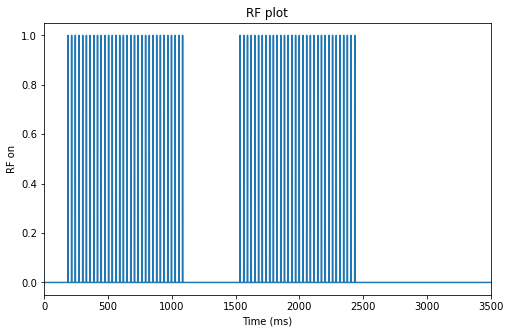

In [3]:
# Scanning parameters from the UK7T protocol:
SSi=3500 # TR between inversions
TR=6.3 # Echo spacing during the shot
TFE=224 # Number of shot per inversion
FAt1=5 # First flip angle
FAt2=2 # Second flip angle
TI1min=590 # Minimum TI for the first shot: need to compute
TI1_=725;# First Inversion Time
TIbis2=5; # Minimum TI for the second shot
TIbis=TI1_ + np.ceil(TFE/2*TR)+TIbis2; # timing for the middle of the sequence
TFE_bis=TFE/2

# Time sampling in 10th of ms
SSi10=SSi*10
T = np.arange(SSi10) # time variable
T0 = np.array(T)/10. # initial time variable
TR10=int(10*TR)
TR9=TR10-1 #TR minus one time tick...
TIbis10=int(TIbis*10)  # TIbisi
TI1_10=int(TI1_*10) # TI1a and TI1i
TI4_10=int(TIbis10+TI1_10) # TI4i

TI0_10=int(TI1_10-np.ceil(TFE_bis*TR10))
TI2_10=int(TI1_10+np.ceil(TFE_bis*TR10))
TI3_10=int(TI4_10-np.ceil(TFE_bis*TR10))
TI5_10=int(TI4_10+np.ceil(TFE_bis*TR10))       

if TI0_10<0:
    os.error('Error, wrong timing: please readjust sequence timing!')

# Create RF timing vector:
RF=np.zeros_like(T,dtype=bool)
for i in range(TI0_10,TI2_10,1):
    if not np.mod(i-TI0_10,TR10):       
        RF[i]=True 
for i in range(TI3_10,TI5_10,1):
    if not np.mod(i-TI3_10,TR10):       
        RF[i]=True 

        
plt.rcParams['figure.figsize'] = [8, 5]
fig1, (ax1) = plt.subplots()
ax1.plot(T0[0:SSi10:10],RF[0:SSi10:10])
ax1.set_title('RF plot')
ax1.set_xlabel('Time (ms)')
ax1.set_xlim(0,SSi)
ax1.set_ylabel('RF on')

Mwm=0.71 # Proton density between WM and GM: no effect on the LUT
Mgm=0.8

FB=180 # Flip angle for the inversion
eff=0.95 # Efficiency of the adiabatic pulse
cosFB=np.cos(np.deg2rad(eff*FB))

expmT1=np.exp(-0.1/T1tmp)
expTRT1=np.exp(-(TR-0.1)/T1tmp)

0.00011157541967398895
0.030355097777336013
0.002426008466699196
0.030665694696409125
0.0023956621304996074
0.03066162221803657
0.0023960600249739446
0.030661675615475746
0.002396054807869186
0.03066167491534029


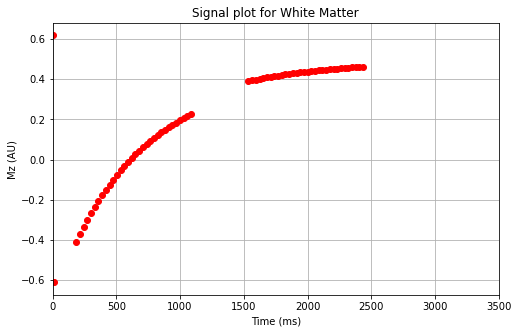

In [4]:
## calculations for signal for white matter

T1tmp = 1050

expmT1=np.exp(-0.1/T1tmp)
expTRT1=np.exp(-(TR-0.1)/T1tmp)

Mwm0=Mwm*(1-np.exp(-SSi/T1tmp))

FA1=FAt1*B1tmp/100;cosFA1=np.cos(np.deg2rad(FA1));sinFA1=np.sin(np.deg2rad(FA1))
FA2=FAt2*B1tmp/100;cosFA2=np.cos(np.deg2rad(FA2));sinFA2=np.sin(np.deg2rad(FA2))

# Initialisation
Mw=np.ones((1,len(T)))*np.nan
Mw[0,0]=Mwm0



# 5 shots to be in steady-state:
# three generally suficient for most B1/T1 combination but 5 necessary for LUT
for shot in range(5):
    # Inversion first: taking into account efficiency and timing of the pulse (12ms)
    Mw[0,1]=cosFB*Mw[0,0]
    Mw[0,120]=Mw[0,1]
    # relaxation before acquisition
    Mw[0,TI0_10-1]=Mwm+(Mw[0,120]-Mwm)*np.exp(-(float(TI0_10-1-120)/10.)/T1tmp)

    i=TI0_10
    while i <= TI1_10:
        if RF[i]:
            Mw[0,i]=Mwm+(cosFA1*Mw[0,i-1]-Mwm)*expmT1 # Every RF pulses
            i+=1
        else:
            Mw[0,i+TR9-1]=Mwm+(Mw[0,i-1]-Mwm)*expTRT1
            i+=TR9

    # Signal in image 1
    WMINV1=sinFA1*Mw[0,TI1_10-1]
    print(WMINV1)

    i=TI1_10
    while i <= TI2_10:
        if RF[i]:
            Mw[0,i]=Mwm+(cosFA1*Mw[0,i-1]-Mwm)*expmT1 # Every RF pulses
            i+=1
        else:
            Mw[0,i+TR9-1]=Mwm+(Mw[0,i-1]-Mwm)*expTRT1
            i+=TR9
            

    # relaxation between the two acquisition
    Mw[0,TI3_10-1]=Mwm+(Mw[0,TI2_10-1]-Mwm)*np.exp(-float(TI3_10-1-TI2_10)/10./T1tmp)

    i=TI3_10
    while i <= TI4_10:
        if RF[i]:
            Mw[0,i]=Mwm+(cosFA2*Mw[0,i-1]-Mwm)*expmT1 # Every RF pulses
            i+=1
        else:
            Mw[0,i+TR9-1]=Mwm+(Mw[0,i-1]-Mwm)*expTRT1
            i+=TR9

    # Signal in image 2
    WMINV2=sinFA2*Mw[0,TI4_10-1] 
    print(WMINV2)

    i=TI4_10
    while i <= TI5_10:
        if RF[i]:
            Mw[0,i]=Mwm+(cosFA2*Mw[0,i-1]-Mwm)*expmT1 # Every RF pulses
            i+=1
        else:
            Mw[0,i+TR9-1]=Mwm+(Mw[0,i-1]-Mwm)*expTRT1
            i+=TR9

    # relaxation after the second acquisition
    Mw[0,SSi10-1]=Mwm+(Mw[0,TI5_10-1]-Mwm)*np.exp(-(float(SSi10-1-TI5_10)/10.)/T1tmp)    

    # Reassignment of magnetisation for the start of the next shot
    Mw[0,0]=Mw[0,SSi10-1]

    
fig2, ax2 = plt.subplots()
ax2.plot(T0[0:SSi10:10],Mw[0,0:SSi10:10],'ro')
ax2.set_title('Signal plot for White Matter')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Mz (AU)')
ax2.set_xlim(0,SSi)
ax2.grid(True)

-0.013506470805308103
0.020914434707771344
-0.007477913156621407
0.022325051594629275
-0.007810331627300742
0.022247269289877462
-0.0077920018631865776
0.022251558255215194
-0.007793012577939584
0.022251321758961686


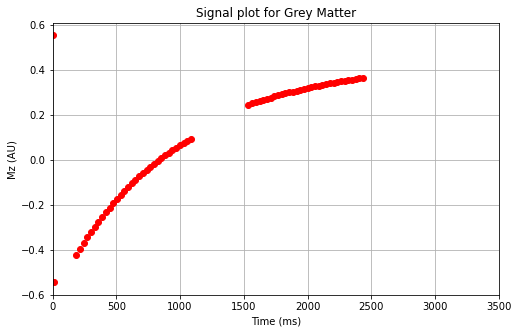

In [5]:
## calculations for signal for grey matter

T1tmp = 1850

expmT1=np.exp(-0.1/T1tmp)
expTRT1=np.exp(-(TR-0.1)/T1tmp)

Mgm0=Mgm*(1-np.exp(-SSi/T1tmp))

FA1=FAt1*B1tmp/100;cosFA1=np.cos(np.deg2rad(FA1));sinFA1=np.sin(np.deg2rad(FA1))
FA2=FAt2*B1tmp/100;cosFA2=np.cos(np.deg2rad(FA2));sinFA2=np.sin(np.deg2rad(FA2))

# Initialisation
Mg=np.ones((1,len(T)))*np.nan
Mg[0,0]=Mgm0


# 5 shots to be in steady-state:
# three generally suficient for most B1/T1 combination but 5 necessary for LUT
for shot in range(5):
    # Inversion first: taking into account efficiency and timing of the pulse (12ms)
    Mg[0,1]=cosFB*Mg[0,0]
    Mg[0,120]=Mg[0,1]
    # relaxation before acquisition
    Mg[0,TI0_10-1]=Mgm+(Mg[0,120]-Mgm)*np.exp(-(float(TI0_10-1-120)/10.)/T1tmp)

    i=TI0_10
    while i <= TI1_10:
        if RF[i]:
            Mg[0,i]=Mgm+(cosFA1*Mg[0,i-1]-Mgm)*expmT1 # Every RF pulses
            i+=1
        else:
            Mg[0,i+TR9-1]=Mgm+(Mg[0,i-1]-Mgm)*expTRT1
            i+=TR9

    # Signal in image 1
    GMINV1=sinFA1*Mg[0,TI1_10-1]
    print(GMINV1)

    i=TI1_10
    while i <= TI2_10:
        if RF[i]:
            Mg[0,i]=Mgm+(cosFA1*Mg[0,i-1]-Mgm)*expmT1 # Every RF pulses
            i+=1
        else:
            Mg[0,i+TR9-1]=Mgm+(Mg[0,i-1]-Mgm)*expTRT1
            i+=TR9  

    # relaxation between the two acquisition
    Mg[0,TI3_10-1]=Mgm+(Mg[0,TI2_10-1]-Mgm)*np.exp(-float(TI3_10-1-TI2_10)/10./T1tmp)

    i=TI3_10
    while i <= TI4_10:
        if RF[i]:
            Mg[0,i]=Mgm+(cosFA2*Mg[0,i-1]-Mgm)*expmT1 # Every RF pulses
            i+=1
        else:
            Mg[0,i+TR9-1]=Mgm+(Mg[0,i-1]-Mgm)*expTRT1
            i+=TR9

    # Signal in image 2
    GMINV2=sinFA2*Mg[0,TI4_10-1] 
    print(GMINV2)

    i=TI4_10
    while i <= TI5_10:
        if RF[i]:
            Mg[0,i]=Mgm+(cosFA2*Mg[0,i-1]-Mgm)*expmT1 # Every RF pulses
            i+=1
        else:
            Mg[0,i+TR9-1]=Mgm+(Mg[0,i-1]-Mgm)*expTRT1
            i+=TR9

    # relaxation after the second acquisition
    Mg[0,SSi10-1]=Mgm+(Mg[0,TI5_10-1]-Mgm)*np.exp(-(float(SSi10-1-TI5_10)/10.)/T1tmp)    

    # Reassignment of magnetisation for the start of the next shot
    Mg[0,0]=Mg[0,SSi10-1]

    
fig2, ax2 = plt.subplots()
ax2.plot(T0[0:SSi10:10],Mg[0,0:SSi10:10],'ro')
ax2.set_title('Signal plot for Grey Matter')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Mz (AU)')
ax2.set_xlim(0,SSi)
ax2.grid(True)

In [6]:
# Calculating PSIR & MP2RAGE signals for white matter with no noise

WMPSIR = WMINV1/(abs(WMINV1)+abs(WMINV2))
WMMP2RAGE = WMINV1*WMINV2/(WMINV1**2+WMINV2**2)

print(WMPSIR)
print(WMMP2RAGE)

0.07248092436870951
0.07767063601134856


In [7]:
# Calculating PSIR & MP2RAGE signals for grey matter with no noise
GMPSIR = GMINV1/(abs(GMINV1)+abs(GMINV2))
GMMP2RAGE = GMINV1*GMINV2/(GMINV1**2+GMINV2**2)

print(GMPSIR)
print(GMMP2RAGE)

-0.2593837656894929
-0.3119620266874503


In [8]:
# Calculating contrast between grey and white matter

CONTRASTMP2 = abs(GMMP2RAGE - WMMP2RAGE)
CONTRASTPSIR = abs(GMPSIR - WMPSIR)

print(CONTRASTMP2)
print(CONTRASTPSIR)

0.38963266269879887
0.3318646900582024


In [9]:
#add noise

def gaussian_noise(x):
    mu = 0
    sigma = abs(Noise * x)
    noise = np.random.normal(mu, sigma, 10000)
    return noise

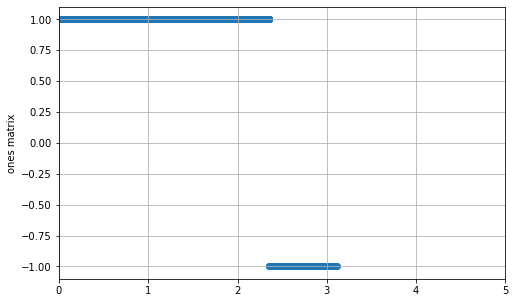

In [10]:
## add noise to white matter

#INV1


WMINV1noise_re = WMINV1 + gaussian_noise(Mwm) #real
WMINV1noise_im = gaussian_noise(Mwm) #imaginary

WMINV1noise = (WMINV1noise_re + 1j*WMINV1noise_im) #real + imaginary

#taking the modulus

WMINV1noise_mod = abs(WMINV1noise)

#getting the phase

WMINV1noise_pha = (np.arctan(WMINV1noise_im/WMINV1noise_re))

#INV2

WMINV2noise_re = WMINV2 + gaussian_noise(Mwm) #real
WMINV2noise_im = gaussian_noise(Mwm) #imaginary

WMINV2noise = (WMINV2noise_re + 1j*WMINV2noise_im) #real + imaginary

#taking the modulus

WMINV2noise_mod = abs(WMINV2noise)

#getting the phase

WMINV2noise_pha = (np.arctan(WMINV2noise_im/WMINV2noise_re))

phasediffWM = abs(WMINV1noise_pha-WMINV2noise_pha)

WMsign = np.where(np.logical_and(phasediffWM>3*np.pi/4,phasediffWM<5*np.pi/4),-1,1)

figWMones, axWMones, = plt.subplots()
axWMones.set_xlim(0,5)
axWMones.set_ylim(-1.1,1.1)
scatter = axWMones.scatter(phasediffWM, WMsign)
axWMones.set_xlabel('')
axWMones.set_ylabel('ones matrix')
axWMones.grid(True)

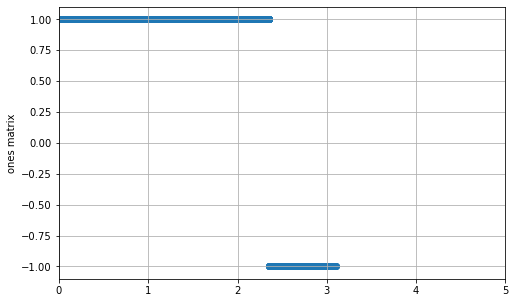

In [11]:
## add noise to grey matter

#INV1


GMINV1noise_re = GMINV1 + gaussian_noise(Mgm) #real
GMINV1noise_im = gaussian_noise(Mgm) #imaginary

GMINV1noise = (GMINV1noise_re + 1j*GMINV1noise_im) #real + imaginary

#taking the modulus

GMINV1noise_mod = abs(GMINV1noise)

#getting the phase

GMINV1noise_pha = (np.arctan(GMINV1noise_im/GMINV1noise_re))

#INV2

GMINV2noise_re = GMINV2 + gaussian_noise(Mgm) #real
GMINV2noise_im = gaussian_noise(Mgm) #imaginary

GMINV2noise = (GMINV2noise_re + 1j*GMINV2noise_im) #real + imaginary

#taking the modulus

GMINV2noise_mod = abs(GMINV2noise)

#getting the phase

GMINV2noise_pha = (np.arctan(GMINV2noise_im/GMINV2noise_re))

phasediffGM = abs(GMINV1noise_pha-GMINV2noise_pha)

GMsign = np.where(np.logical_and(phasediffGM>3*np.pi/4,phasediffGM<5*np.pi/4),-1,1)

figGMones, axGMones, = plt.subplots()
axGMones.set_xlim(0,5)
axGMones.set_ylim(-1.1,1.1)
scatter = axGMones.scatter(phasediffGM, GMsign)
axGMones.set_xlabel('')
axGMones.set_ylabel('ones matrix')
axGMones.grid(True)

In [12]:
# Calculating PSIR & MP2RAGE signals for white matter with noise

WMPSIR_noise = WMsign*WMINV1noise_mod/(abs(WMINV1noise)+abs(WMINV2noise))
WMMP2RAGE_noise = WMsign*WMINV1noise*np.conj(WMINV2noise)/(WMINV1noise**2+WMINV2noise**2)

print(WMPSIR_noise)
print(WMMP2RAGE_noise)

[ 0.55348334  0.55474012  0.51412602 ...  0.6698529   0.52128462
 -0.5089036 ]
[ 0.59727578+0.51918495j  0.19457624+1.23646345j -0.79617277-0.5135975j
 ...  0.41116806-0.28617736j -0.49034925-0.19131702j
  0.5092313 -0.33262571j]


In [13]:
# Calculating PSIR & MP2RAGE signals for grey matter with noise

GMPSIR_noise =  GMsign*abs(GMINV1noise)/(abs(GMINV1noise)+abs(GMINV2noise))
GMMP2RAGE_noise = GMsign*GMINV1noise*np.conj(GMINV2noise)/(GMINV1noise**2+GMINV2noise**2)
print(GMPSIR_noise)
print(GMMP2RAGE_noise)

[-0.4700065   0.41245193  0.566067   ...  0.27863057  0.66782858
  0.54025927]
[-0.64121502+0.1375201j   0.06751431-0.53571926j -0.36646011+0.34716735j
 ...  0.34498806+0.06273237j -0.5427785 -0.37063902j
  0.51954622+0.54178797j]


In [14]:
# Calculating average contrast between grey and white matter with noise

def avg(s):
    avg = sum(s)/len(s)
    return(avg)

contrastPSIR_noise = avg(WMPSIR_noise) - avg(GMPSIR_noise)
contrastMP2RAGE_noise = avg(WMMP2RAGE_noise) - avg(GMMP2RAGE_noise)

print(contrastPSIR_noise)


-0.0012815899588130009


In [15]:
# Contrast to noise ratio calculations

denominator_PSIR = (np.sqrt(np.std(WMPSIR_noise)**2 + np.std(GMPSIR_noise)**2))

denominator_MP2RAGE = (np.sqrt((np.std(WMMP2RAGE_noise)**2 + np.std(GMMP2RAGE_noise)**2)))

CNR_PSIR = contrastPSIR_noise/denominator_PSIR

CNR_MP2RAGE = contrastMP2RAGE_noise/denominator_MP2RAGE

print(CNR_PSIR)
print(CNR_MP2RAGE)

#Below is CNR for TR = 5.8ms

-0.003001326243125566
(0.0010304144554761328-0.0015157077417886021j)


C:\Users\ppzom1\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


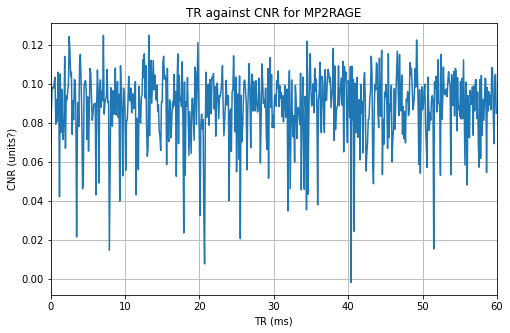

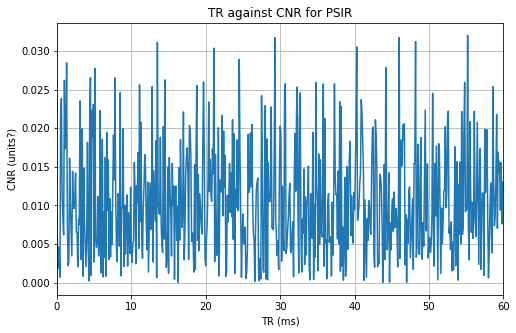

In [16]:
TR_array = np.arange(0,60,0.1)
CNR_MP2RAGE_array = []
CNR_PSIR_array = []
for TR in TR_array:
    def gaussian_noise(x):
        mu = 0
        sigma = abs(Noise * x)
        noise = np.random.normal(mu, sigma, 10000)
        return noise
    ## add noise to white matter

    #INV1

    WMINV1noise_re = WMINV1 + gaussian_noise(Mwm) #real
    WMINV1noise_im = gaussian_noise(Mwm) #imaginary

    WMINV1noise = (WMINV1noise_re + 1j*WMINV1noise_im) #real + imaginary

    #taking the modulus

    WMINV1noise_mod = abs(WMINV1noise)

    #getting the phase

    WMINV1noise_pha = (np.arctan(WMINV1noise_im/WMINV1noise_re))

    #INV2

    WMINV2noise_re = WMINV2 + gaussian_noise(Mwm) #real
    WMINV2noise_im = gaussian_noise(Mwm) #imaginary

    WMINV2noise = (WMINV2noise_re + 1j*WMINV2noise_im) #real + imaginary

    #taking the modulus

    WMINV2noise_mod = abs(WMINV2noise)

    #getting the phase

    WMINV2noise_pha = (np.arctan(WMINV2noise_im/WMINV2noise_re))

    phasediffWM = abs(WMINV1noise_pha-WMINV2noise_pha)

    WMsign = np.where(np.logical_and(phasediffWM>3*np.pi/4,phasediffWM<5*np.pi/4),-1,1)
    ## add noise to grey matter

    #INV1

    GMINV1noise_re = GMINV1 + gaussian_noise(Mgm) #real
    GMINV1noise_im = gaussian_noise(Mgm) #imaginary

    GMINV1noise = (GMINV1noise_re + 1j*GMINV1noise_im) #real + imaginary

    #taking the modulus

    GMINV1noise_mod = abs(GMINV1noise)

    #getting the phase

    GMINV1noise_pha = (np.arctan(GMINV1noise_im/GMINV1noise_re))

    #INV2

    GMINV2noise_re = GMINV2 + gaussian_noise(Mgm) #real
    GMINV2noise_im = gaussian_noise(Mgm) #imaginary

    GMINV2noise = (GMINV2noise_re + 1j*GMINV2noise_im) #real + imaginary

    #taking the modulus

    GMINV2noise_mod = abs(GMINV2noise)

    #getting the phase

    GMINV2noise_pha = (np.arctan(GMINV2noise_im/GMINV2noise_re))

    phasediffGM = abs(GMINV1noise_pha-GMINV2noise_pha)

    GMsign = np.where(np.logical_and(phasediffGM>3*np.pi/4,phasediffGM<5*np.pi/4),-1,1)

    # Calculating PSIR & MP2RAGE signals for white matter with noise

    WMPSIR_noise = WMsign*WMINV1noise_mod/(abs(WMINV1noise)+abs(WMINV2noise))
    WMMP2RAGE_noise = WMINV2noise/(WMINV1noise**2+WMINV2noise**2)

    # Calculating PSIR & MP2RAGE signals for grey matter with noise

    GMPSIR_noise =  GMsign*GMINV1noise_mod/(abs(GMINV1noise)+abs(GMINV2noise))
    GMMP2RAGE_noise = GMINV1noise*GMINV2noise/(GMINV1noise**2+GMINV2noise**2)
    # Calculating average contrast between grey and white matter with noise

    def avg(s):
        avg = sum(s)/len(s)
        return(avg)

    contrastPSIR_noise = abs(avg(WMPSIR_noise) - avg(GMPSIR_noise))
    contrastMP2RAGE_noise = avg(WMMP2RAGE_noise) - avg(GMMP2RAGE_noise)

    # Contrast to noise ratio calculations

    denominator_PSIR = np.sqrt(np.std(WMPSIR_noise)**2 + np.std(GMPSIR_noise)**2)

    denominator_MP2RAGE = np.sqrt(np.std(WMMP2RAGE_noise)**2 + np.std(GMMP2RAGE_noise)**2)

    CNR_PSIR = contrastPSIR_noise/denominator_PSIR

    CNR_MP2RAGE = contrastMP2RAGE_noise/denominator_MP2RAGE
    
    CNR_MP2RAGE_array = np.append(CNR_MP2RAGE_array,CNR_MP2RAGE)
    CNR_PSIR_array = np.append(CNR_PSIR_array,CNR_PSIR)


    #Below is CNR for TR = 5.8ms

    
figTRMP2, axTRMP2, = plt.subplots()
axTRMP2.plot(TR_array, CNR_MP2RAGE_array)
axTRMP2.set_title('TR against CNR for MP2RAGE')
axTRMP2.set_xlabel('TR (ms)')
axTRMP2.set_ylabel('CNR (units?)')
axTRMP2.set_xlim(0,60)
axTRMP2.grid(True)

figTRPSIR, axTRPSIR, = plt.subplots()
axTRPSIR.plot(TR_array, CNR_PSIR_array)
axTRPSIR.set_title('TR against CNR for PSIR')
axTRPSIR.set_xlabel('TR (ms)')
axTRPSIR.set_ylabel('CNR (units?)')
axTRPSIR.set_xlim(0,60)
axTRPSIR.grid(True)